# Выбор локации для скважины

Мы работаем в добывающей компании «ГлавРосГосНефть». Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

**Цель:** Нужно решить, где бурить новую скважину.

**Задачи:** 
1. Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 
2. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

    id — уникальный идентификатор скважины;
    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    product — объём запасов в скважине (тыс. баррелей).
    
**Условия задачи:**

    1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
    2. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
    3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
    4. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
    5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
    6. Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Импортируем нужные библиотеки

In [1]:
# Импортируем нужные библиотеки

from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

### Через конструкцию try-except прочтем файлы и сохраним их в переменные

In [2]:
# Через конструкцию try-except прочтем файлы и сохраним их в переменные
try:
    df_1 = pd.read_csv('/datasets/geo_data_0.csv')
    df_2 = pd.read_csv('/datasets/geo_data_1.csv')
    df_3 = pd.read_csv('/datasets/geo_data_2.csv')
except FileNotFoundError:
    print("FileNotFoundError: Проверьте корректность пути к файлу или наличие самого файла в каталоге!")

### Выведем размерность датасетов (строка-столбец) 

In [3]:
# Выведем размерность датасетов (строка-столбец)
print(df_1.shape, df_2.shape, df_3.shape)

(100000, 5) (100000, 5) (100000, 5)


### Просмотрим первые 5 строк для первого датасета  в первом датасете

In [4]:
# Просмотрим первые 5 строк для первого датасета в первом датасете
df_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


### Просмотрим информацию об датасете в первом датасете

In [5]:
# Просмотрим информацию об датасете в первом датасете
df_1.info

<bound method DataFrame.info of           id        f0        f1        f2     product
0      txEyH  0.705745 -0.497823  1.221170  105.280062
1      2acmU  1.334711 -0.340164  4.365080   73.037750
2      409Wp  1.022732  0.151990  1.419926   85.265647
3      iJLyR -0.032172  0.139033  2.978566  168.620776
4      Xdl7t  1.988431  0.155413  4.751769  154.036647
...      ...       ...       ...       ...         ...
99995  DLsed  0.971957  0.370953  6.075346  110.744026
99996  QKivN  1.392429 -0.382606  1.273912  122.346843
99997  3rnvd  1.029585  0.018787 -1.348308   64.375443
99998  7kl59  0.998163 -0.528582  1.583869   74.040764
99999  1CWhH  1.764754 -0.266417  5.722849  149.633246

[100000 rows x 5 columns]>

### Проверим количество пропусков в первом датасете

In [6]:
# Проверим количество пропусков в первом датасете
df_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

### Через цикл проверим на наличие дубликатов в первом датасете

In [7]:
# Через цикл проверим на наличие дубликатов в первом датасете
for x in df_1.columns:
    print("Кол-во явных дубликтов для столбца", x, "равняется", df_1[x].duplicated().sum())

Кол-во явных дубликтов для столбца id равняется 10
Кол-во явных дубликтов для столбца f0 равняется 0
Кол-во явных дубликтов для столбца f1 равняется 0
Кол-во явных дубликтов для столбца f2 равняется 0
Кол-во явных дубликтов для столбца product равняется 0


### Визуализируем наши признаки в первом датасете

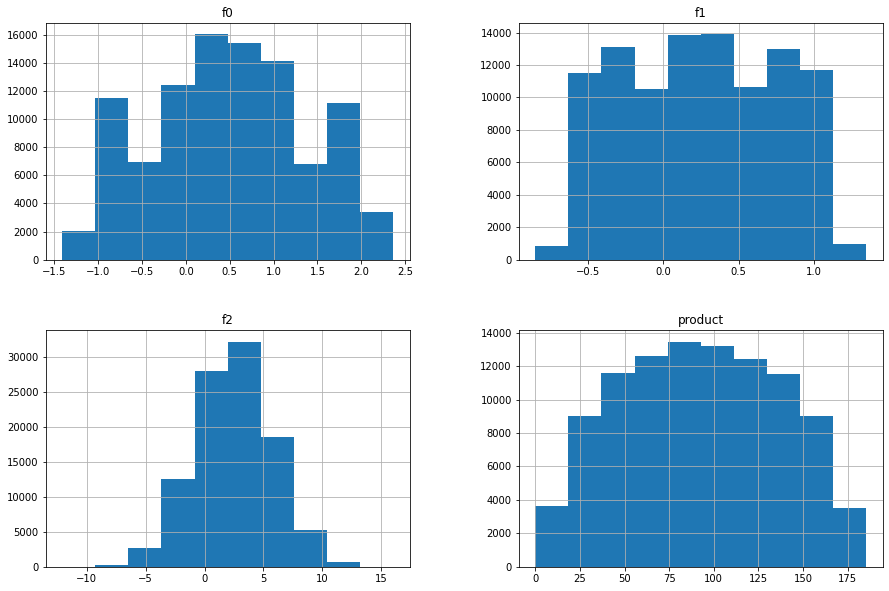

In [8]:
# Визуализируем наши признаки в первом датасете
df_1.hist(figsize=(15, 10))
plt.show()

# Проделаем аналогичные шаги для второго и третьего датасетов и в конце сделаем выводы

****

In [9]:
df_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
df_2.info

<bound method DataFrame.info of           id         f0         f1        f2     product
0      kBEdx -15.001348  -8.276000 -0.005876    3.179103
1      62mP7  14.272088  -3.475083  0.999183   26.953261
2      vyE1P   6.263187  -5.948386  5.001160  134.766305
3      KcrkZ -13.081196 -11.506057  4.999415  137.945408
4      AHL4O  12.702195  -8.147433  5.004363  134.766305
...      ...        ...        ...       ...         ...
99995  QywKC   9.535637  -6.878139  1.998296   53.906522
99996  ptvty -10.160631 -12.558096  5.005581  137.945408
99997  09gWa  -7.378891  -3.084104  4.998651  137.945408
99998  rqwUm   0.665714  -6.152593  1.000146   30.132364
99999  relB0  -3.426139  -7.794274 -0.003299    3.179103

[100000 rows x 5 columns]>

In [11]:
df_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [12]:
for x in df_2.columns:
    print("Кол-во явных дубликтов для столбца", x, "равняется", df_2[x].duplicated().sum())

Кол-во явных дубликтов для столбца id равняется 4
Кол-во явных дубликтов для столбца f0 равняется 0
Кол-во явных дубликтов для столбца f1 равняется 0
Кол-во явных дубликтов для столбца f2 равняется 0
Кол-во явных дубликтов для столбца product равняется 99988


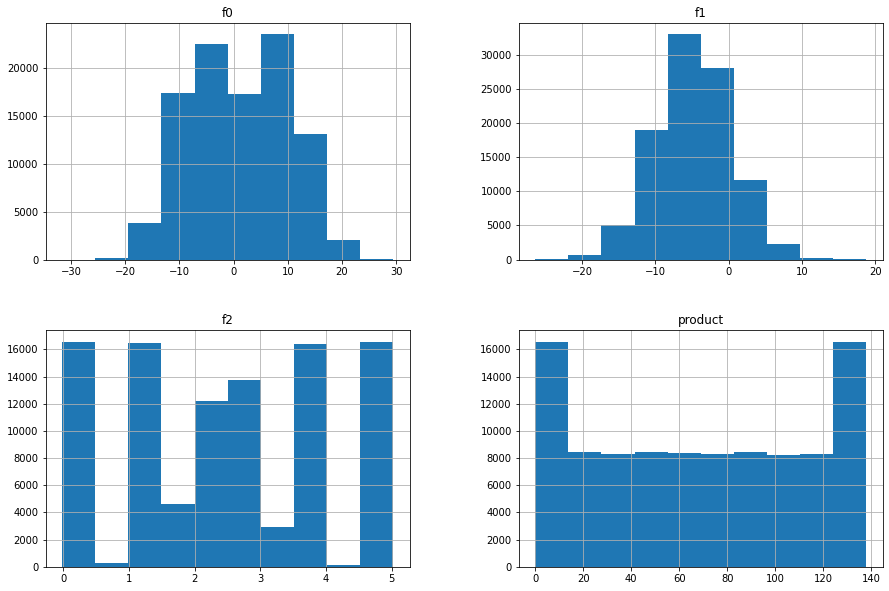

In [13]:
df_2.hist(figsize=(15, 10))
plt.show()

****

In [14]:
df_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [15]:
df_3.info

<bound method DataFrame.info of           id        f0        f1        f2     product
0      fwXo0 -1.146987  0.963328 -0.828965   27.758673
1      WJtFt  0.262778  0.269839 -2.530187   56.069697
2      ovLUW  0.194587  0.289035 -5.586433   62.871910
3      q6cA6  2.236060 -0.553760  0.930038  114.572842
4      WPMUX -0.515993  1.716266  5.899011  149.600746
...      ...       ...       ...       ...         ...
99995  4GxBu -1.777037  1.125220  6.263374  172.327046
99996  YKFjq -1.261523 -0.894828  2.524545  138.748846
99997  tKPY3 -1.199934 -2.957637  5.219411  157.080080
99998  nmxp2 -2.419896  2.417221 -5.548444   51.795253
99999  V9kWn -2.551421 -2.025625  6.090891  102.775767

[100000 rows x 5 columns]>

In [16]:
df_3.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [17]:
for x in df_3.columns:
    print("Кол-во явных дубликтов для столбца", x, "равняется", df_3[x].duplicated().sum())

Кол-во явных дубликтов для столбца id равняется 4
Кол-во явных дубликтов для столбца f0 равняется 0
Кол-во явных дубликтов для столбца f1 равняется 0
Кол-во явных дубликтов для столбца f2 равняется 0
Кол-во явных дубликтов для столбца product равняется 0


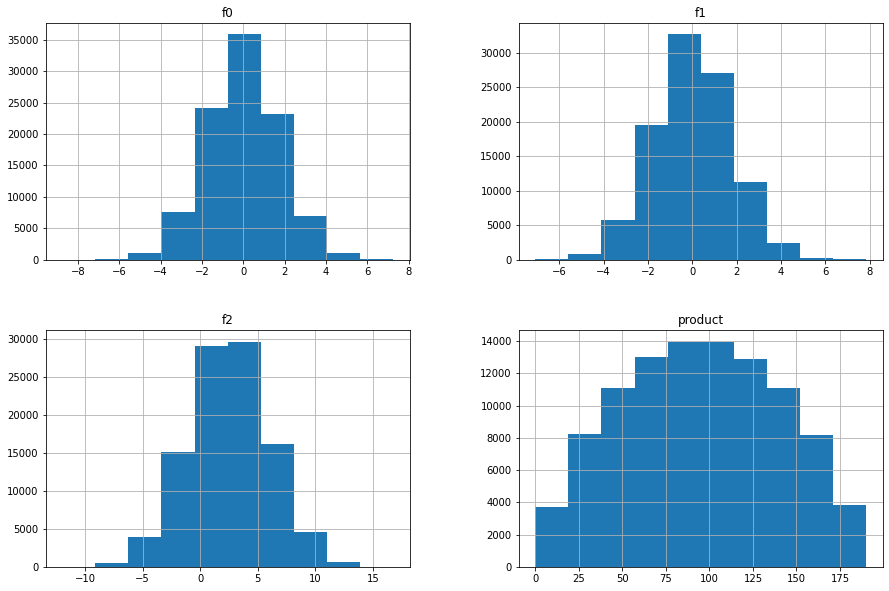

In [18]:
df_3.hist(figsize=(15, 10))
plt.show()

### Выводы по загрузке и подготовке данных

1. Признаки в трех датасетах не содеражат пропусков, потому не требуется предобработки пропущенных значений
2. Во всех трех датасетах для столбца(признака) id имеется несколько дубликатов, что не мешает дальнейшему исследованию и анализу данных, однако следует понимать, что id в идеале не должны быть одинаковы
3. Видно, что для 3-го датасета признаки f1, f2 и f3 очень близки к нормальному распределению, в отличии от 1 датасета, а для 2-го датасета прослеживается сильное отличие в признаках f3 и product по сравнению с первым и третьим датасетами
4. Для 2-го датасета видно кол-во явных дубликтов для столбца product равное 99988 - что сильно отличает и выделяет данный датасет

****

## Обучение и проверка модели

### Разобьем для каждого датасета признаки и целевой признак

In [19]:
# для 1-го датасета:
features_1 = df_1.drop(['product', 'id'], axis=1)
target_1 = df_1['product']

# для 2-го датасета:
features_2 = df_2.drop(['product', 'id'], axis=1)
target_2 = df_2['product']

# для 3-го датасета:
features_3 = df_3.drop(['product', 'id'], axis=1)
target_3 = df_3['product']

### Для каждого датасета разделим на тренировочную и валидационную выборки в соотношении 75:25 (3:1)

In [20]:
# для 1-го датасета:
features_train_1, features_validate_1, target_train_1, target_validate_1 = train_test_split(features_1, 
                                                                                            target_1, 
                                                                                            train_size=0.75,
                                                                                            random_state=42)

# для 2-го датасета:
features_train_2, features_validate_2, target_train_2, target_validate_2 = train_test_split(features_2, 
                                                                                            target_2, 
                                                                                            train_size=0.75,
                                                                                            random_state=42)
# для 3-го датасета:
features_train_3, features_validate_3, target_train_3, target_validate_3 = train_test_split(features_3, 
                                                                                            target_3, 
                                                                                            train_size=0.75,
                                                                                            random_state=42)

# Линейная регрессия

### Обучим модели для каждого региона и сделаем предсказания на валидационной выборке

    Создадим функцию для обучения и предсказаний 
    Оценим: средний предсказанный запас, MSE, RMSE и r2_score

In [21]:
def func_model(model, target_v, predictions_valid,):
    mse = mean_squared_error(target_v, predictions_valid) # посчитаем значение метрики MSE на валидационной выборк
    result = mean_squared_error(target_v, predictions_valid) ** 0.5  # посчитаем значение метрики RMSE на валидационной выборке
    r2 = r2_score(target_v, predictions_valid) # посчитаем значение метрики r2_score на валидационной выборке
    print(f"Для модели соотвествуюшие показатели равняются:")
    print("Средний запас предсказанного сырья:", predictions_valid.mean())
    print("MSE модели линейной регрессии на валидационной выборке:", mse)
    print("RMSE модели линейной регрессии на валидационной выборке:", result)
    print("R2:", r2)
    print()

### Модели для датасетов

In [22]:
model_1 = LinearRegression() 
model_1.fit(features_train_1, target_train_1) # обучим модель на тренировочной выборке
predictions_valid_1 = model_1.predict(features_validate_1) # получим предсказания модели на валидационной выборке

model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2) # обучим модель на тренировочной выборке
predictions_valid_2 = model_2.predict(features_validate_2) # получим предсказания модели на валидационной выборке

model_3 = LinearRegression() 
model_3.fit(features_train_3, target_train_3) # обучим модель на тренировочной выборке
predictions_valid_3 = model_3.predict(features_validate_3) # получим предсказания модели на валидационной выборке

print("Модель 1")
model_final_1 = func_model(model_1, target_validate_1, predictions_valid_1)
print("Модель 2")
model_final_2 = func_model(model_2, target_validate_2, predictions_valid_2)
print("Модель 3")
model_final_3 = func_model(model_3, target_validate_3, predictions_valid_3)


Модель 1
Для модели соотвествуюшие показатели равняются:
Средний запас предсказанного сырья: 92.39879990657768
MSE модели линейной регрессии на валидационной выборке: 1425.5608700093812
RMSE модели линейной регрессии на валидационной выборке: 37.75660035026169
R2: 0.2728287328173471

Модель 2
Для модели соотвествуюшие показатели равняются:
Средний запас предсказанного сырья: 68.71287803913762
MSE модели линейной регрессии на валидационной выборке: 0.7925986566392013
RMSE модели линейной регрессии на валидационной выборке: 0.890280100102884
R2: 0.9996245232002449

Модель 3
Для модели соотвествуюшие показатели равняются:
Средний запас предсказанного сырья: 94.77102387765939
MSE модели линейной регрессии на валидационной выборке: 1611.6910636385903
RMSE модели линейной регрессии на валидационной выборке: 40.145872311342174
R2: 0.19634705977280487



### Выводы по обучению и подготовке модели

1. Наибольшие средние запасы предсказанного сырья в датасетах 1 и 3
2. Видно, что для 2-го датасета расчет MSE и RMSE был не таким как для 1-го и 3-го датасетов
3. Наилучшая оценка R2 имеется у второго датасета и равна 0.9996245232002449: это говорит о том, если r2_score равен 1, зависимая переменная может быть безошибочно предсказана по независимой переменной, - что мы и имеем у второго датасета

## Подготовка к расчёту прибыли

In [23]:
# расчеты с сокращением численных показателей

BUDGET = 10000 # бюджет в млн рублей (* 1 000 000)
POINTS_PER_BUDGET = 200 # количество разрабатываемых точек 
PRODUCT_PRICE = 0.45 # доходность одной единицы барреля в млн рублей (* 1 000 000)

BUDGET_PER_POINT =  BUDGET/POINTS_PER_BUDGET  # сколько бюджета в (млн) приходится на 1-скважину
PRODUCT_VALUE_POINT = BUDGET_PER_POINT / PRODUCT_PRICE # сколько бюджет на 1-скважину в (млн) приходится на доходность одной единицы барреля

print(BUDGET_PER_POINT)
print(PRODUCT_VALUE_POINT)


50.0
111.11111111111111


In [24]:
# расчеты без сокращения численных показателей

BUDGET_2 = 10000000000 # бюджет в млн рублей 
POINTS_PER_BUDGET_2 = 200 # количество разрабатываемых точек 
PRODUCT_PRICE_2 = 450000 # доходность одной единицы барреля в млн рублей 

BUDGET_PER_POINT_2 =  BUDGET_2/POINTS_PER_BUDGET_2  # сколько бюджета вприходится на 1-скважину
PRODUCT_VALUE_POINT_2 = BUDGET_PER_POINT_2 / PRODUCT_PRICE_2 # сколько бюджет на 1-скважину приходится на доходность одной единицы барреля

print(BUDGET_PER_POINT_2)
print(PRODUCT_VALUE_POINT_2)

50000000.0
111.11111111111111


****

# Расчёт прибыли и рисков 

# Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [25]:
def profit(target, predictions_valid, count):
    probs_sorted = predictions_valid.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    losses = target[probs_sorted.index][count:]
    return PRODUCT_PRICE * selected.sum() - BUDGET

### Расчет для первого датасета

In [26]:
state = np.random.RandomState(12345) # создание переменной, чтобы случайный элемент не был всегда одинаковый.
values = [] # создание переменной-списка для хранения отобранных функцией
for i in range(1000):
    target_subsample = target_validate_1.sample(frac=None, replace=True, random_state=state, n=500, axis=0)
    probs_subsample = pd.Series(data=predictions_valid_1, index=target_validate_1.index)[target_subsample.index]
    values.append(profit(target_subsample, probs_subsample, 200))
    
values = pd.Series(values)
mean = values.mean()
risk = values.quantile(0.975)
risk_2 = values.quantile(0.025)
print("Средняя прибыль:", mean)
print("0.975% квантиль =", risk)
print("0.025% квантиль =", risk_2)

negative = []
for x in values:
    if x < 0:
        negative.append(x)

print('Доля случаев, в которых прибыль отрицательна =', len(negative) / len(values) * 100, '%')
# print(len(negative))
# print(len(values))

Средняя прибыль: 435.9337721386624
0.975% квантиль = 966.5041807073762
0.025% квантиль = -116.23161277720891
Доля случаев, в которых прибыль отрицательна = 6.1 %


### Расчет для второго датасета

In [27]:
state = np.random.RandomState(12345) # создание переменной, чтобы случайный элемент не был всегда одинаковый.
values = [] # создание переменной-списка для хранения отобранных функцией
for i in range(1000):
    target_subsample = target_validate_2.sample(frac=None, replace=True, random_state=state, n=500, axis=0)
    probs_subsample = pd.Series(data=predictions_valid_2, index=target_validate_2.index)[target_subsample.index]
    values.append(profit(target_subsample, probs_subsample, 200))

values = pd.Series(values)
mean = values.mean()
risk = values.quantile(0.975)
risk_2 = values.quantile(0.025)
print("Средняя прибыль:", mean)
print("0.975% квантиль =", risk)
print("0.025% квантиль =", risk_2)


negative = []
for x in values:
    if x < 0:
        negative.append(x)

print('Доля случаев, в которых прибыль отрицательна =', len(negative) / len(values) * 100, '%')

Средняя прибыль: 489.6612544117528
0.975% квантиль = 905.7626504248394
0.025% квантиль = 55.11617727361514
Доля случаев, в которых прибыль отрицательна = 1.0999999999999999 %


### Расчет для третьего датасета

In [28]:
state = np.random.RandomState(12345) # создание переменной, чтобы случайный элемент не был всегда одинаковый.
values = [] # создание переменной-списка для хранения отобранных функцией
for i in range(1000):
    target_subsample = target_validate_3.sample(frac=None, replace=True, random_state=state, n=500, axis=0)
    probs_subsample = pd.Series(data=predictions_valid_3, index=target_validate_3.index)[target_subsample.index]
    values.append(profit(target_subsample, probs_subsample, 200))

values = pd.Series(values)
mean = values.mean()
risk = values.quantile(0.975)
risk_2 = values.quantile(0.025)
print("Средняя прибыль:", mean)
print("0.975% квантиль =", risk)
print("0.025% квантиль =", risk_2)


negative = []
for x in values:
    if x < 0:
        negative.append(x)

print('Доля случаев, в которых прибыль отрицательна =', len(negative) / len(values) * 100, '%')

Средняя прибыль: 403.68792786213874
0.975% квантиль = 952.8874167078604
0.025% квантиль = -153.11698476190503
Доля случаев, в которых прибыль отрицательна = 7.1 %


**4) Выводы по расчету прибыли и рисков:**

    На основании полученных данных можно предложить 2 регион для разработки скважин и выбор обосновывается следующим ходом мыслей:
    1) В данном регионе наибольшая средняя прибыль
    2) 0.025% квантиль показывает, что все что за этим параметром, очень маловероятно,  и так как здесь у нас положительный результат, в отличии от других регионов - то риск убытка существенно меньше 
    3) Доля убытков для второго региона наименьшая 

## Общий вывод по проекту

**1) Сделали выводы по загрузке и подготовке данных:**
1. Признаки в трех датасетах не содеражат пропусков, потому не требуется предобработки пропущенных значений
2. Во всех трех датасетах для столбца(признака) id имеется несколько дубликатов, что не мешает дальнейшему исследованию и анализу данных, однако следует понимать, что id в идеале не должны быть одинаковы
3. Видно, что для 3-го датасета признаки f1, f2 и f3 очень близки к нормальному распределению, в отличии от 1 датасета, а для 2-го датасета прослеживается сильное отличие в признаках f3 и product по сравнению с первым и третьим датасетами
4. Для 2-го датасета видно кол-во явных дубликтов для столбца product равное 99988 - что сильно отличает и выделяет данный датасет

**2.1) Разбили для каждого датасета признаки и целевой признак**

**2.2) Для каждого датасета разделили на тренировочную и валидационную выборки в соотношении 75:25 (3:1)**

**2.3) Обучили модель для каждого региона и сделали предсказания на валидационной выборке**

    Создадим функцию для обучения и предсказаний 
    Оценим: средний предсказанный запас, MSE, RMSE и r2_score
    
**2) Привели выводы по обучению и подготовке модели:**

1. Наибольшие средние запасы предсказанного сырья в датасетах 1 и 3
2. Видно, что для 2-го датасета расчет MSE и RMSE был не таким как для 1-го и 3-го датасетов
3. Наилучшая оценка R2 имеется у второго датасета и равна 0.9996245232002449: это говорит о том, если r2_score равен 1, зависимая переменная может быть безошибочно предсказана по независимой переменной, - что мы и имеем у второго датасета

**3) Была выполнена подготовка к расчёту прибыли:**
       
       budget = 10000 # бюджет в млн рублей
       points_per_budget = 200 # количество разрабатываемых точек
       product_price = 0.45 # доходность одной единицы барреля в млн рублей
       budget_per_point = 50.0 # сколько бюджета в (млн) приходится на 1-скважину
       product_value_point = 111.11111111111111 #сколько бюджет на 1-скважину приходится на доходность одной единицы барреля

**4.1) Была написана функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:** 

**4) Выводы по расчету прибыли и рисков:**

    На основании полученных данных можно предложить 2 регион для разработки скважин и выбор обосновывается следующим ходом мыслей:
    1) В данном регионе наибольшая средняя прибыль
    2) 0.025% квантиль показывает, что все что за этим параметром, очень маловероятно,  и так как здесь у нас положительный результат, в отличии от других регионов - то риск убытка существенно меньше 
    3) Доля убытков для второго региона наименьшая 
    
**Цель проекта была достигнута:**
        
        Предложен 2-регион и обоснован выбор